In [44]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

# Batch_Norm 

In [33]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

(train_images, train_labels),(test_images,test_labels) = mnist.load_data()
train_images = train_images.reshape((-1,28,28,1))
test_images = test_images.reshape((-1,28,28,1))

train_images = train_images/255.
test_images = test_images/255.

valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels,
                                                                        test_size=0.15, shuffle=True)

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

In [35]:
class ConvBNRelu(Model):
    def __init__(self, filters, kernel_size=3, strides=(1,1), padding='same'):
        super(ConvBNRelu, self).__init__()
        self.conv = Conv2D(filters=filters, kernel_size=kernel_size,
                           strides=strides, padding=padding,
                           kernel_initializer='glorot_normal')
        self.batchnorm = BatchNormalization()
        
    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        
        return layer

In [36]:
class DenseBNRelu(Model):
    def __init__(self, units): # units는 input값
        super(DenseBNRelu, self).__init__()
        self.dense = Dense(units=units, kernel_initializer='glorot_normal')
        self.batchnorm = BatchNormalization()
        
    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        
        return layer

In [37]:
class MNISTModel(Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=32, kernel_size=(3,3), padding='valid')
        self.pool1 = MaxPool2D()
        self.conv2 = ConvBNRelu(filters=64, kernel_size=(3,3), padding='valid')
        self.pool2 = MaxPool2D()
        self.conv3 = ConvBNRelu(filters=64, kernel_size=(3,3), padding='valid')
        self.flat = Flatten()
        self.dense4 = DenseBNRelu(units=64)
        self.drop = Dropout(0.2)
        self.outputs = Dense(10, activation='softmax')
        
    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.flat(net)
        net = self.dense4(net)
        net = self.drop(net)
        net = self.outputs(net)
        
        return net

In [38]:
model = MNISTModel()
model(Input(shape=(28,28,1)))
model.summary()

Model: "mnist_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_relu_16 (ConvBNRelu  multiple                 448       
 )                                                               
                                                                 
 max_pooling2d_10 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv_bn_relu_17 (ConvBNRelu  multiple                 18752     
 )                                                               
                                                                 
 max_pooling2d_11 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv_bn_relu_18 (ConvBNRelu  multiple               

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/Users/suchan/study/cnn_models/'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

# save best only = val_accuracy가 있는 값들 중 좋아진 경우에만 save
# save weight only = 모델의 weight값만 갖고옴
cb_checkpoint = ModelCheckpoint(filepath=model_path,
                                monitor='val_accuracy',
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

# patience = val_accuracy가 연속으로 n번 떨어지면 STOP
cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [40]:
learning_rate = 0.001
batch_size = 200

lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, train_images.shape[0]/batch_size*5, 0.5, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
hist = model.fit(train_images, train_labels,
                 validation_data=(valid_images, valid_labels),
                 epochs=100, batch_size=batch_size,
                 callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100


2022-03-04 14:04:36.587848: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-04 14:04:36.898205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9520

2022-03-04 14:04:43.286782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.30141, saving model to /Users/suchan/study/cnn_models/mnist-1-2.67033-0.30141.hdf5
300/300 [==============================] - 7s 16ms/step - loss: 0.1989 - accuracy: 0.9520 - val_loss: 2.6703 - val_accuracy: 0.3014
Epoch 2/100
297/300 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9870
Epoch 2: val_accuracy improved from 0.30141 to 0.96565, saving model to /Users/suchan/study/cnn_models/mnist-2-0.10755-0.96565.hdf5
300/300 [==============================] - 5s 15ms/step - loss: 0.0490 - accuracy: 0.9870 - val_loss: 0.1076 - val_accuracy: 0.9656
Epoch 3/100
297/300 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9911
Epoch 3: val_accuracy improved from 0.96565 to 0.98612, saving model to /Users/suchan/study/cnn_models/mnist-3-0.04298-0.98612.hdf5
300/300 [==============================] - 5s 15ms/step - loss: 0.0323 - accuracy: 0.9912 - val_loss: 0.0430 - val_accuracy: 0.9861
Epoch 4/100
300/

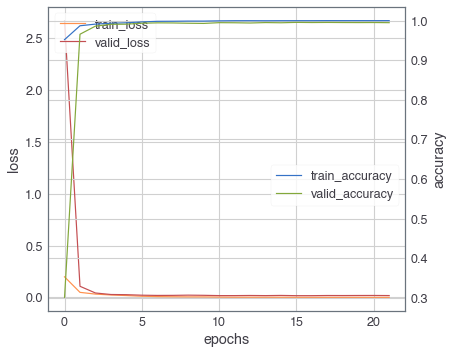

In [45]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='valid_accuracy')
acc_ax.set_xlabel('epochs')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

plt.show()

# VGG16

In [68]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [69]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


### VGG 디폴트 shape(3채널)에 데이터 맞추기

In [70]:
train_images = train_images.reshape(-1,784).astype('float32')
test_images = test_images.reshape(-1, 784).astype('float32')

In [71]:
train_images = np.dstack([train_images]*3)
test_images = np.dstack([test_images]*3)

In [72]:
# 이미지 형식으로 변경
train_images = train_images.reshape(-1,28,28,3)
test_images = test_images.reshape(-1,28,28,3)

In [73]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [74]:
# 48 * 48 사이즈로 변경
train_images = np.asarray([img_to_array(array_to_img(img, scale=False).resize((48,48))) for img in train_images])
test_images = np.asarray([img_to_array(array_to_img(img, scale=False).resize((48,48))) for img in test_images])
valid_images = np.asarray([img_to_array(array_to_img(img, scale=False).resize((48,48))) for img in valid_images])

In [75]:
train_images = train_images/255.
test_images = test_images/255.

In [76]:
valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.15, shuffle=True)

In [77]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [78]:
layer_dict = {layer.name : layer for layer in vgg_model.layers}
layer_dict

{'input_3': <keras.engine.input_layer.InputLayer at 0x326119760>,
 'block1_conv1': <keras.layers.convolutional.Conv2D at 0x32982fc10>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x32982f6d0>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x32982ffd0>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x326233820>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x329802b80>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x3261197f0>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x32618f850>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x326102220>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x326191730>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x329a6aee0>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x31f9405e0>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x32984ddc0>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x3260128b0>,
 'block4_pool': <keras.layers.pooling.Ma

In [79]:
x = layer_dict['block2_conv2'].output

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x)

In [80]:
custom_model = Model(inputs=vgg_model.input, outputs=x)
custom_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 conv2d_20 (Conv2D)          (None, 22, 22, 64)        7379

In [81]:
for layer in custom_model.layers[:7]:
    layer.trainable = False

custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER = '/Users/suchan/study/cnn_models/'
model_path = f"{MODEL_SAVE_FOLDER}mnist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

# save best only = val_accuracy가 있는 값들 중 좋아진 경우에만 save
# save weight only = 모델의 weight값만 갖고옴
cb_checkpoint = ModelCheckpoint(filepath=model_path,
                                monitor='val_accuracy',
                                verbose=1,
                                save_weights_only=True,
                                save_best_only=True)

# patience = val_accuracy가 연속으로 n번 떨어지면 STOP
cb_early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

In [83]:
hist = custom_model.fit(train_images, train_labels,
                 validation_data=(valid_images, valid_labels),
                 epochs=100, batch_size=batch_size,
                 callbacks=[cb_checkpoint, cb_early_stopping])

Epoch 1/100


2022-03-04 15:56:26.283112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


299/300 [============================>.] - ETA: 0s - loss: 1.6394 - accuracy: 0.8419

2022-03-04 15:56:37.959150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.97153, saving model to /Users/suchan/study/cnn_models/mnist-1-0.10412-0.97153.hdf5
300/300 [==============================] - 13s 43ms/step - loss: 1.6349 - accuracy: 0.8422 - val_loss: 0.1041 - val_accuracy: 0.9715
Epoch 2/100
299/300 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9387
Epoch 2: val_accuracy improved from 0.97153 to 0.97859, saving model to /Users/suchan/study/cnn_models/mnist-2-0.07133-0.97859.hdf5
300/300 [==============================] - 13s 42ms/step - loss: 0.1988 - accuracy: 0.9387 - val_loss: 0.0713 - val_accuracy: 0.9786
Epoch 3/100
299/300 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9526
Epoch 3: val_accuracy did not improve from 0.97859
300/300 [==============================] - 13s 42ms/step - loss: 0.1536 - accuracy: 0.9526 - val_loss: 0.0778 - val_accuracy: 0.9773
Epoch 4/100
299/300 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.95

In [84]:
saved_path = '/Users/suchan/study/cnn_models/mnist-21-0.03736-0.99059.hdf5'
custom_model.load_weights(saved_path)

custom_model.evaluate(test_images, test_labels)

47/47 [==============================] - 1s 11ms/step - loss: 0.0813 - accuracy: 0.9813


[0.0812864750623703, 0.981333315372467]